## Import Libraries

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.io import write_html

## Define Dataset Paths

In [2]:
materials = pd.read_csv("../data/processed/clean_materials.csv")
df = pd.read_csv("../data/processed/final_ecopack_dataset_fe.csv")

print(materials.columns)
print(df.columns)

Index(['Material_ID', 'Material_Name', 'Category', 'Density_kg_m3',
       'Tensile_Strength_MPa', 'Cost_per_kg', 'CO2_Emission_kg',
       'Biodegradable'],
      dtype='object')
Index(['Category_item', 'Weight_kg', 'Volumetric_Weight_kg', 'Fragility',
       'Moisture_Sens', 'Shipping_Mode', 'Distance_km', 'Packaging_Used',
       'Cost_USD', 'CO2_Emission_kg_item', 'Material_ID', 'Material_Name',
       'Category_material', 'Density_kg_m3', 'Tensile_Strength_MPa',
       'Cost_per_kg', 'CO2_Emission_kg_material', 'Biodegradable',
       'co2_impact_index', 'cost_efficiency_index',
       'environmental_impact_score', 'material_suitability_score',
       'sustainability_score', 'sustainability_rating', 'Item_Volume_m3'],
      dtype='object')


In [3]:
upper_cap = df["sustainability_score"].quantile(0.999)

df = df[df["sustainability_score"] <= upper_cap]

In [4]:
df["sustainability_score"].describe()

count    14984.000000
mean         2.738142
std          4.601368
min          0.000000
25%          0.459092
50%          1.122210
75%          2.171453
max         62.999213
Name: sustainability_score, dtype: float64

In [5]:
df = df[~(
    (df["sustainability_score"] > 1) &   
    (df["Fragility"] == 9) &
    (df["Shipping_Mode"].str.lower() == "road")
)]

## 📊 1️⃣ KPI OVERVIEW 

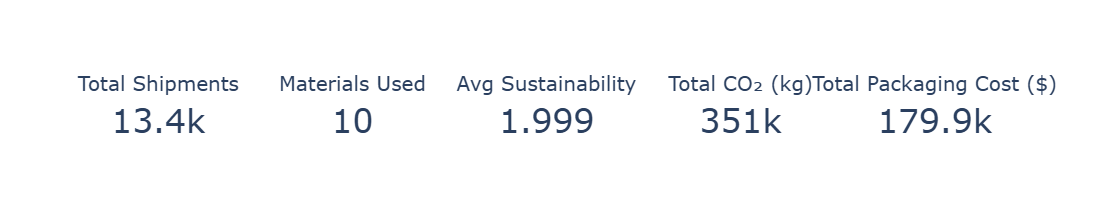

In [6]:
kpis = {
    "Total Shipments": len(df),
    "Materials Used": df["Material_ID"].nunique(),
    "Avg Sustainability": df["sustainability_score"].mean(),
    "Total CO₂ (kg)": df["CO2_Emission_kg_item"].sum(),
    "Total Packaging Cost ($)": df["Cost_USD"].sum()
}

fig_kpi = make_subplots(rows=1, cols=len(kpis), specs=[[{"type": "indicator"}]*len(kpis)])

for i, (k, v) in enumerate(kpis.items(), start=1):
    fig_kpi.add_trace(
        go.Indicator(
            mode="number",
            value=v,
            title={"text": k}
        ),
        row=1, col=i
    )

fig_kpi.update_layout(height=220, template="plotly_white")
fig_kpi.show()

## 📊 2️⃣ MATERIAL USAGE vs FULL CATALOG 

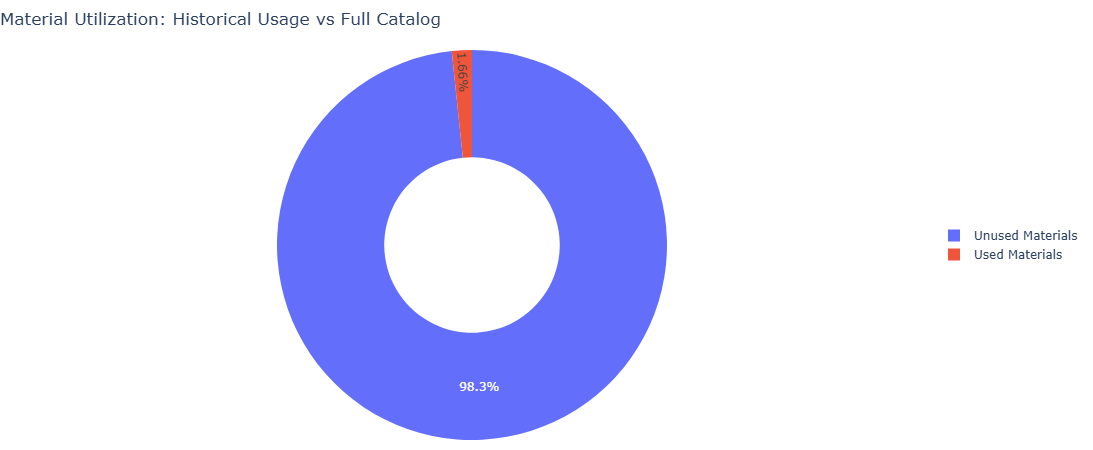

In [7]:
used_materials = df["Material_ID"].nunique()
unused_materials = materials["Material_ID"].nunique() - used_materials

fig_usage = px.pie(
    names=["Used Materials", "Unused Materials"],
    values=[used_materials, unused_materials],
    hole=0.45,  # smaller hole → slightly smaller donut
    title="Material Utilization: Historical Usage vs Full Catalog"
)

# Update layout for fixed size and legend on right
fig_usage.update_layout(
    title=dict(x=0, xanchor='left'),
    legend=dict(x=1, y=0.5),  # keep legend on right-middle
    height=450,
    width=500,
    margin=dict(l=10, r=10, t=50, b=10)  # reduce extra whitespace
)

fig_usage.show()

### 🔥 This visually proves only ~10 of 600 materials are used.

## 📊 3️⃣ COST & CO₂ CONCENTRATION 

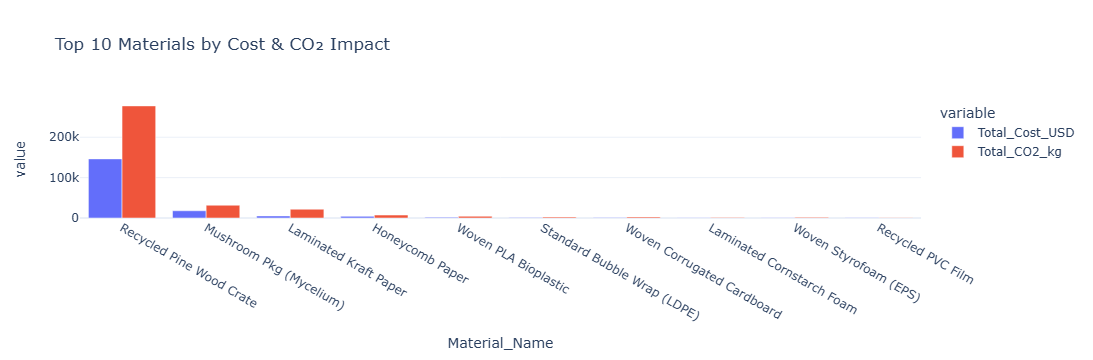

In [8]:
top_materials = (
    df.groupby("Material_Name")
      .agg(
          Total_Cost_USD=("Cost_USD", "sum"),
          Total_CO2_kg=("CO2_Emission_kg_item", "sum"),
          Shipments=("Material_ID", "count")
      )
      .sort_values("Total_Cost_USD", ascending=False)
      .head(10)
      .reset_index()
)

fig_pareto = px.bar(
    top_materials,
    x="Material_Name",
    y=["Total_Cost_USD", "Total_CO2_kg"],
    barmode="group",
    title="Top 10 Materials by Cost & CO₂ Impact",
    template="plotly_white"
)

fig_pareto.show()

## 📊 4️⃣ COST vs CO₂ vs SUSTAINABILITY 

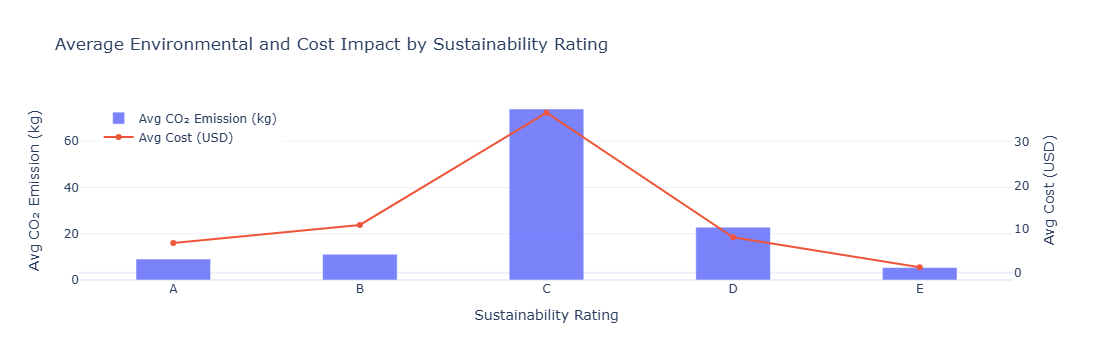

In [9]:
agg_df = (
    df.groupby("sustainability_rating")
      .agg(
          avg_co2=("CO2_Emission_kg_item", "mean"),
          avg_cost=("Cost_USD", "mean")
      )
      .reset_index()
      .sort_values("sustainability_rating")
)

fig_line_bar = go.Figure()

# Bar: Avg CO2
fig_line_bar.add_trace(
    go.Bar(
        x=agg_df["sustainability_rating"],
        y=agg_df["avg_co2"],
        name="Avg CO₂ Emission (kg)",
        opacity=0.85,
        width=0.4
    )
)

# Line: Avg Cost
fig_line_bar.add_trace(
    go.Scatter(
        x=agg_df["sustainability_rating"],
        y=agg_df["avg_cost"],
        name="Avg Cost (USD)",
        mode="lines+markers",
        yaxis="y2"
    )
)

fig_line_bar.update_layout(
    title="Average Environmental and Cost Impact by Sustainability Rating",
    xaxis_title="Sustainability Rating",
    yaxis=dict(
        title="Avg CO₂ Emission (kg)",
        showgrid=True
    ),
    yaxis2=dict(
        title="Avg Cost (USD)",
        overlaying="y",
        side="right",
        showgrid=False
    ),
    template="plotly_white",
    legend=dict(x=0.02, y=0.98)
)

fig_line_bar.show()

### How to read this ? 
#### 🔴 High cost + high CO₂ → replace immediately

#### 🟢 Low cost + low CO₂ → ideal materials

#### 🟡 High cost + low CO₂ → negotiate pricing

#### 🔵 Low cost + high CO₂ → environmental risk

## 📊 5️⃣ UNUSED MATERIALS – OPPORTUNITY LANDSCAPE

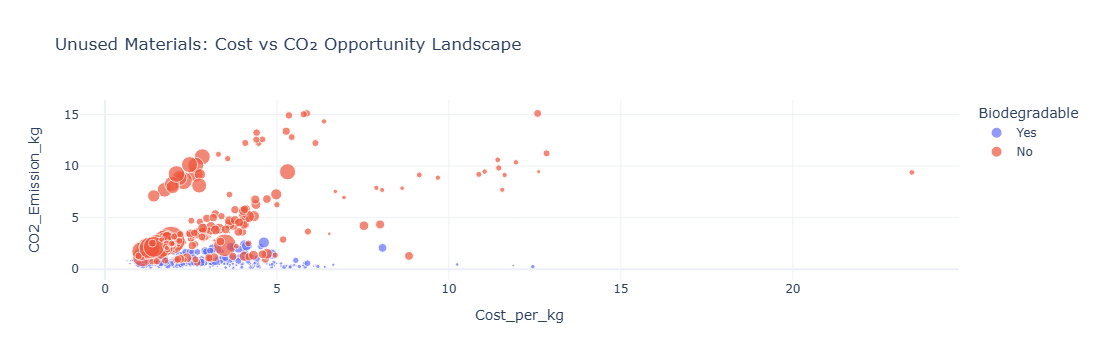

In [10]:
unused_materials = materials[
    ~materials["Material_ID"].isin(df["Material_ID"].unique())
]

fig_unused = px.scatter(
    unused_materials,
    x="Cost_per_kg",
    y="CO2_Emission_kg",
    size="Tensile_Strength_MPa",
    color="Biodegradable",
    hover_data=["Material_Name", "Category"],
    title="Unused Materials: Cost vs CO₂ Opportunity Landscape",
    template="plotly_white"
)

fig_unused.show()

### 🔥 This feeds recommendation engine logic.

## 📊 6️⃣ Avg Sustainability Score by Rating

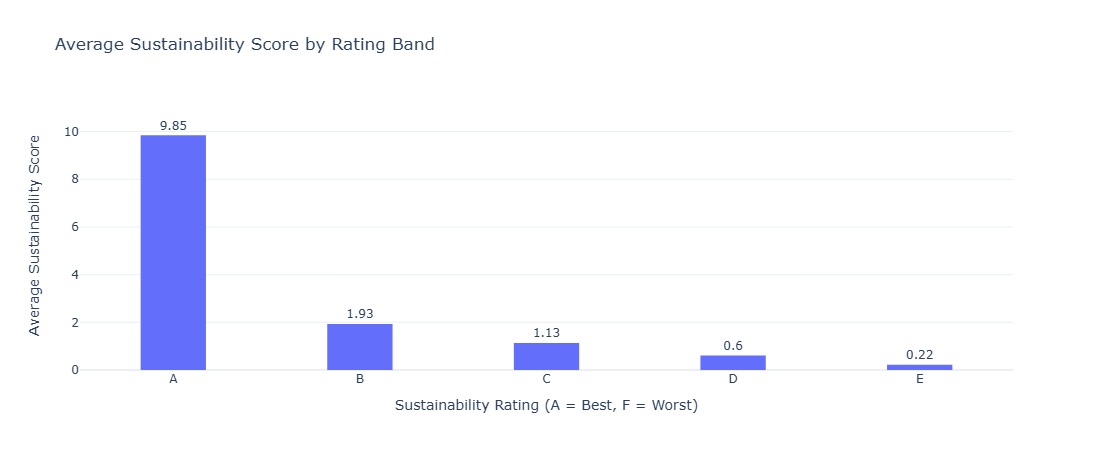

In [11]:
rating_order = ["A", "B", "C", "D", "E", "F"]

avg_by_rating = (
    df
    .groupby("sustainability_rating", as_index=False)["sustainability_score"]
    .mean()
)

avg_by_rating["sustainability_rating"] = pd.Categorical(
    avg_by_rating["sustainability_rating"],
    categories=rating_order,
    ordered=True
)

avg_by_rating = avg_by_rating.sort_values("sustainability_rating")

fig_rating = px.bar(
    avg_by_rating,
    x="sustainability_rating",
    y="sustainability_score",
    text=avg_by_rating["sustainability_score"].round(2),
    title="Average Sustainability Score by Rating Band",
    template="plotly_white"
)

fig_rating.update_traces(
    width=0.35,                 # 👈 slimmer bars
    textposition="outside",
    marker_line_width=0
)
max_score = avg_by_rating["sustainability_score"].max()

fig_rating.update_layout(
    xaxis_title="Sustainability Rating (A = Best, F = Worst)",
    yaxis_title="Average Sustainability Score",
    yaxis=dict(range=[0, max_score * 1.15]),
    bargap=0.2,                 # 👈 spacing between bars
    height=450,
    width=500
)

fig_rating.show()

## 📊 7️⃣ A) Distance vs CO₂ — Faceted by Mode

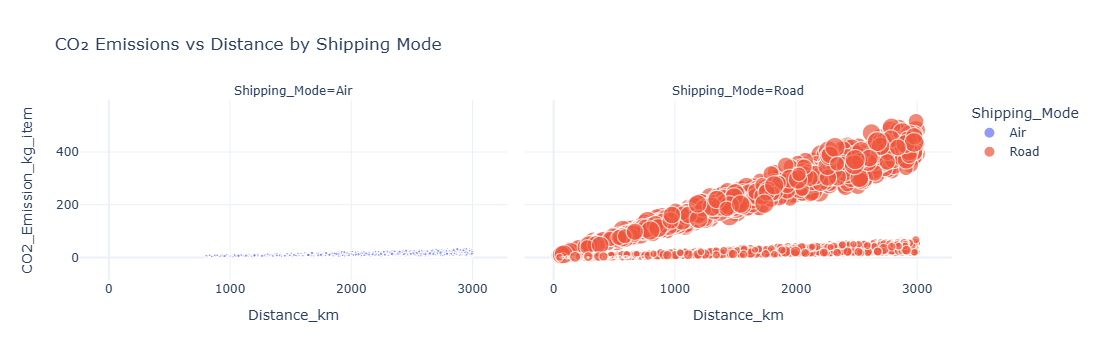

In [12]:
fig_mode_distance = px.scatter(
    df,
    x="Distance_km",
    y="CO2_Emission_kg_item",
    color="Shipping_Mode",
    size="Weight_kg",
    facet_col="Shipping_Mode",
    title="CO₂ Emissions vs Distance by Shipping Mode",
    template="plotly_white"
)

fig_mode_distance.show()

## 📊 7️⃣ B) CO₂ per km Comparison (VERY STRONG KPI) -> This normalizes distance

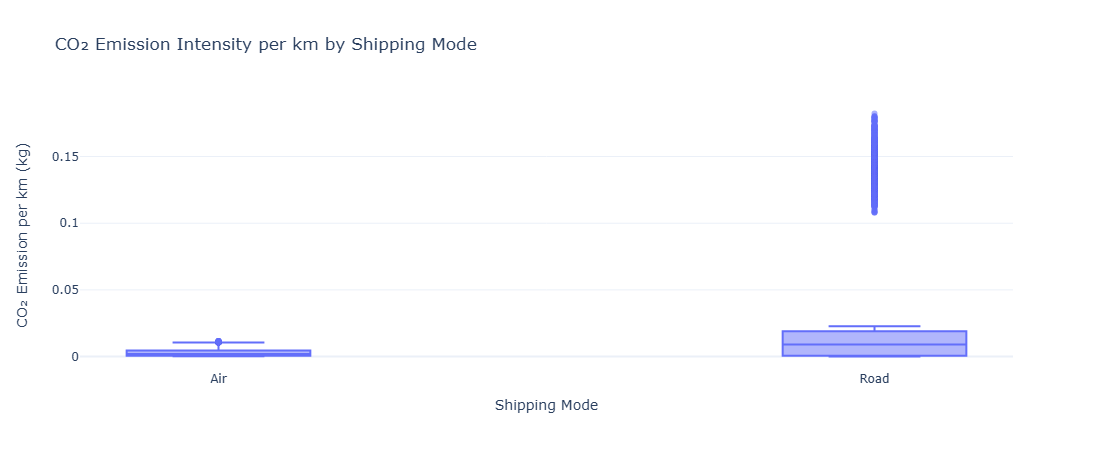

In [13]:
df["CO2_per_km"] = df["CO2_Emission_kg_item"] / df["Distance_km"]

fig_co2_km = px.box(
    df,
    x="Shipping_Mode",
    y="CO2_per_km",
    title="CO₂ Emission Intensity per km by Shipping Mode",
    template="plotly_white"
)

fig_co2_km.update_traces(
    width=0.28,                  
    boxpoints="outliers",
    marker=dict(opacity=0.55)
)

fig_co2_km.update_layout(
    yaxis_title="CO₂ Emission per km (kg)",
    xaxis_title="Shipping Mode",
    height=450,
    width=500
)

fig_co2_km.show()

## 📊 8️⃣ FRAGILITY vs MATERIAL STRENGTH (FIT ANALYSIS)

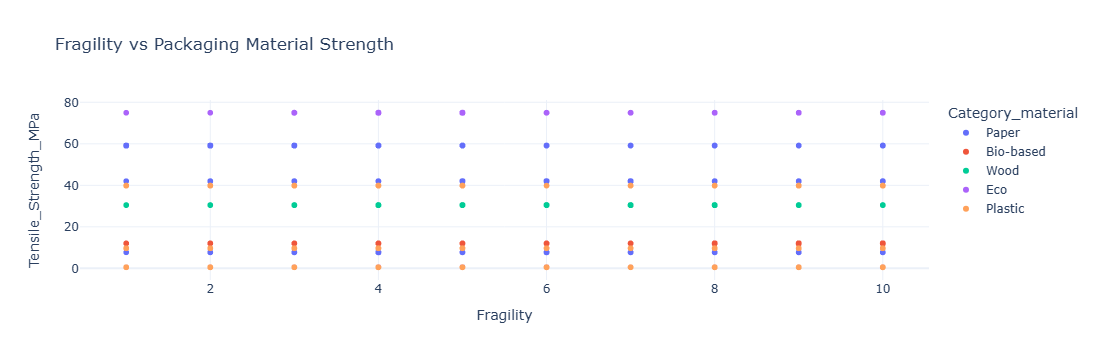

In [14]:
fig_fragility = px.scatter(
    df,
    x="Fragility",
    y="Tensile_Strength_MPa",
    color="Category_material",
    title="Fragility vs Packaging Material Strength",
    template="plotly_white"
)

fig_fragility.show()

## 📊 9️⃣ FEATURE CORRELATION HEATMAP (DATA SCIENCE VIEW)

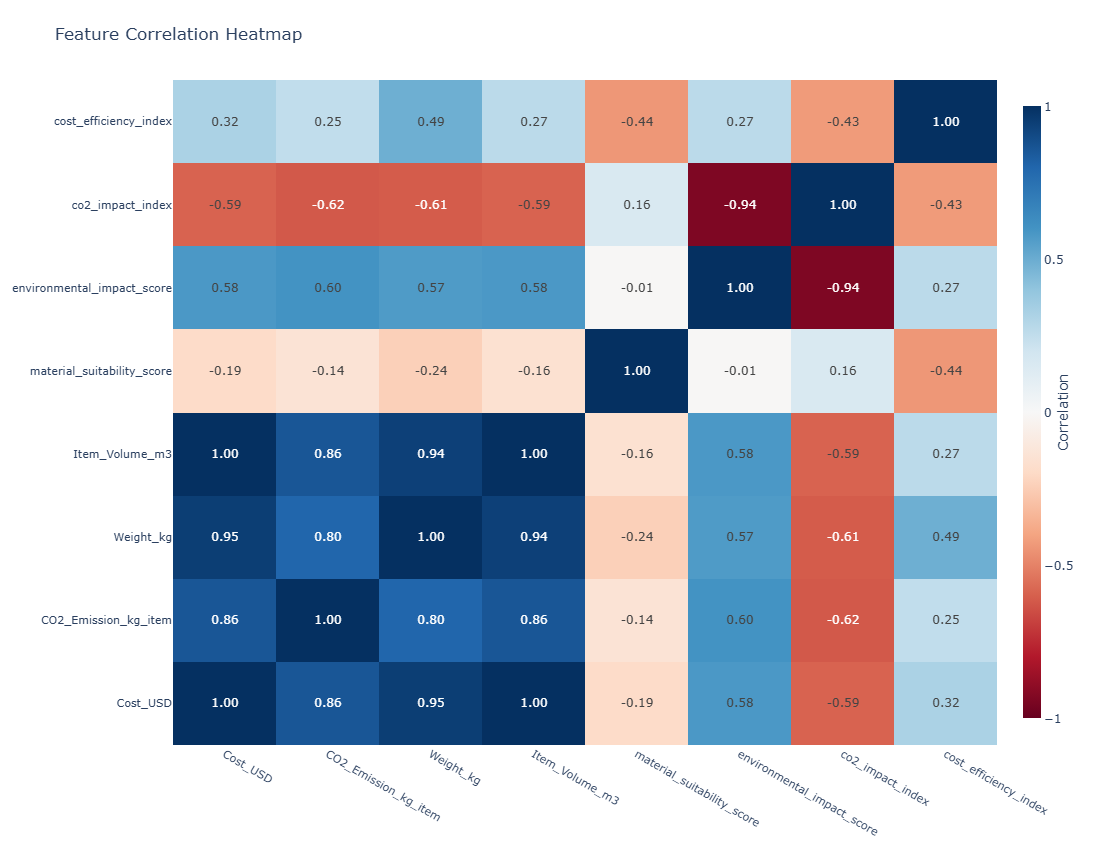

In [15]:
numeric_cols = [
    "Cost_USD",
    "CO2_Emission_kg_item",
    "Weight_kg",
    "Item_Volume_m3",
    "material_suitability_score",
    "environmental_impact_score",
    "co2_impact_index",
    "cost_efficiency_index"
]

corr = df[numeric_cols].corr().round(2)

fig_corr = go.Figure(
    data=go.Heatmap(
        z=corr.values,
        x=corr.columns,
        y=corr.columns,
        text=corr.values,
        texttemplate="%{text:.2f}",
        colorscale="RdBu",
        zmid=0,
        colorbar=dict(
            title="Correlation",
            titleside="right",
            len=0.95,          # ⬅ long colorbar
            thickness=18
        )
    )
)

fig_corr.update_layout(
    title="Feature Correlation Heatmap",
    template="plotly_white",
    height=850,             # ⬅ BIG matrix
    width=900,
    margin=dict(l=80, r=80, t=80, b=80),
    xaxis=dict(tickfont=dict(size=11)),
    yaxis=dict(tickfont=dict(size=11))
)

fig_corr.show()

## 📊 🔟 Fragility vs Sustainability (Optimization Check) -> Are we over-engineering packaging for low-fragility items?

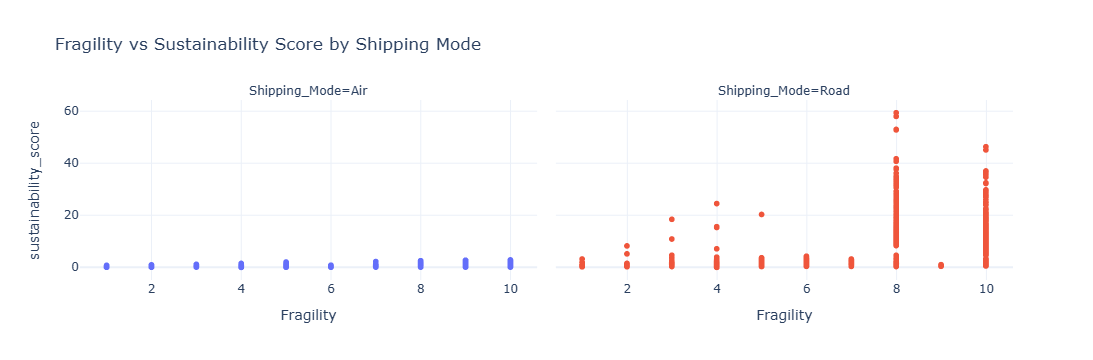

In [16]:
import plotly.express as px

fig_frag_sust = px.scatter(
    df,
    x="Fragility",
    y="sustainability_score",
    color="Shipping_Mode",
    facet_col="Shipping_Mode",          # 👈 key line
    title="Fragility vs Sustainability Score by Shipping Mode",
    template="plotly_white"
)

fig_frag_sust.update_layout(showlegend=False)

fig_frag_sust.show()

### Interpretation:

#### 🟢 High sustainability for low fragility → over-packaging

#### 🔴 Low sustainability for high fragility → risk zone

## 📊 Open all plots in one dashboard

In [17]:
html_path = "EcoPackAI_BI_Dashboard.html"

with open(html_path, "w", encoding="utf-8") as f:
    f.write("""
    <!DOCTYPE html>
    <html>
    <head>
        <meta charset="utf-8">
        <title>EcoPackAI – BI Dashboard</title>
        <style>
            body {
                margin: 0;
                padding: 20px;
                font-family: Arial, sans-serif;
                background-color: #fafafa;
            }
            .chart {
                margin-bottom: 40px;
            }
        </style>
    </head>
    <body>
        <h1>🌱 EcoPackAI – Business Intelligence Dashboard</h1>
    """)

    # 1️⃣ KPI Overview
    f.write('<div class="chart">')
    f.write(fig_kpi.to_html(full_html=False, include_plotlyjs="cdn"))
    f.write('</div>')

    # 2️⃣ Material Usage vs Full Catalog
    f.write('<div class="chart">')
    f.write(fig_usage.to_html(full_html=False, include_plotlyjs=False))
    f.write('</div>')

    # 3️⃣ Top Materials – Cost & CO₂ Pareto
    f.write('<div class="chart">')
    f.write(fig_pareto.to_html(full_html=False, include_plotlyjs=False))
    f.write('</div>')

    # 4️⃣ Cost(line) vs CO₂(bar) vs Sustainability
    f.write('<div class="chart">')
    f.write(fig_line_bar.to_html(full_html=False, include_plotlyjs=False))
    f.write('</div>')

    # 5️⃣ Unused Materials Opportunity Map
    f.write('<div class="chart">')
    f.write(fig_unused.to_html(full_html=False, include_plotlyjs=False))
    f.write('</div>')

    # 6️⃣ Avg Sustainability Score by Rating
    f.write('<div class="chart">')
    f.write(fig_rating.to_html(full_html=False, include_plotlyjs=False))
    f.write('</div>')

    # 7️⃣ A. CO₂ vs Distance by Shipping Mode
    f.write('<div class="chart">')
    f.write(fig_mode_distance.to_html(full_html=False, include_plotlyjs=False))
    f.write('</div>')

    # 7️⃣ B. CO₂ per km by Shipping Mode
    f.write('<div class="chart">')
    f.write(fig_co2_km.to_html(full_html=False, include_plotlyjs=False))
    f.write('</div>')

    # 8️⃣ Fragility vs Material Strength
    f.write('<div class="chart">')
    f.write(fig_fragility.to_html(full_html=False, include_plotlyjs=False))
    f.write('</div>')

    # 9️⃣ Feature Correlation Heatmap
    f.write('<div class="chart">')
    f.write(fig_corr.to_html(full_html=False, include_plotlyjs=False))
    f.write('</div>')

    # 🔟 Fragility vs Sustainability Optimization
    f.write('<div class="chart">')
    f.write(fig_frag_sust.to_html(full_html=False, include_plotlyjs=False))
    f.write('</div>')

    f.write("""
    </body>
    </html>
    """)